**Date**: 2018-07-11

**Authors**: Yichen Fang, Adam Stafford

**Purpose**: To test the relationship between validation accuracy and alignment length.

This notebook tests a naive alignment scheme that selects the first 1500 positions of a DNA sequence (add null positions to the end if a sequence is shorter than 1500).

**Background**:
- This notebook is a follow-up experiment of `2018-07-11_lstm_naive_trimming_size_2000.ipynb`.
- This notebook uses the one-hot encoded dna data buffered in `data/list_buffer.txt`. The buffered data is a concatenation of all files in `data/output` folder. The purpose of the buffering is to speed up the notebook.
- The output data in `data/output` folder is based on the input data in folders `data/input/3.24_species_only` (the dna sequence data), and `data/input/5_TFBS_score_subset_30May2018` (the TFBS motif data).
- The output data can be reproduced by running `code/utility/producing_output_files.ipynb` (not needed for running this notebook).
- The data include 10752 dna sequences, each trimmed to a length of 1500 positions. For each position, one-hot encoding is applied, and three TFBS motif scores are attached. 9600 sequences are used as training sequences, among which 960 sequences are served as validation sequences.
- There may be slight variation in the accuracy results in each rerun of the experient due to the inherent shuffling randomness of LSTM RNN network.
- The notebook is catered for running on a computer that utilizes TensorFlow GPU acceleration. To run the notebook on a computer without GPU acceleration, change all `CuDNNLSTM` to `LSTM` (beware that the neural network training would be extremely slow without GPU acceleration).

**Experiment**:

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

Load the `pickle` buffered list:

In [3]:
with open("../data/list_buffer.txt", "rb") as buff:
    seq_record_list = pickle.load(buff)

The following cell transforms the data into a format that is recognizable by the neural network model.

In [4]:
# A helper function to flatten a 2d list to 1d.
# Input: [[1, 2], [2, 3], [3, 4, 5]]
# Output: [1, 2, 2, 3, 3, 4, 5]
def flatten(lst):
    new_lst = []
    for sub_lst in lst:
        for item in sub_lst:
            new_lst.append(item)
    return new_lst

# A helper function to transform a lst so that its length becomes read_len by:
# 1. If len(lst) > read_len, curtail the end of the lst.
# 2. If len(lst) < read_len, keep extending the end of the lst with 0 (NA).
def curtail(lst, read_len):
    if len(lst) > read_len:
        lst = lst[:read_len]
    else:
        for i in range(read_len - len(lst)):
            lst.append([0, 0, 0, 0, 0, 0, 0])
    return lst

# Produce the train-test split
# length_read: the length that you want all DNA sequences to conform to
def prepare_input(training_size, test_size, length_read):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    seq_count = 0
    while seq_count < training_size:
        X_train.append(flatten(curtail(seq_record_list[seq_count][3], length_read)))
        y_train.append(int(seq_record_list[seq_count][1]))
        seq_count += 1
    while seq_count < (training_size + test_size):
        X_test.append(flatten(curtail(seq_record_list[seq_count][3], length_read)))
        y_test.append(int(seq_record_list[seq_count][1]))
        seq_count += 1
    return X_train, y_train, X_test, y_test

# Turn list into numpy tensors that can directly feed into a neural network model
def to_np_array(X_train, y_train, X_test, y_test):
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    if len(y_train.shape) == 1:
        y_train = np.transpose(np.array([y_train]))
    X_test = np.array(X_test)
    y_test = np.transpose(np.array(y_test))
    if len(y_test.shape) == 1:
        y_test = np.transpose(np.array([y_test]))
    return X_train, y_train, X_test, y_test

In [5]:
X_train, y_train, X_test, y_test = prepare_input(9600, 1152, 1500)
X_train, y_train, X_test, y_test = to_np_array(X_train, y_train, X_test, y_test)
[X_train.shape, y_train.shape, X_test.shape, y_test.shape]

[(9600, 10500), (9600, 1), (1152, 10500), (1152, 1)]

The following cells build a recurrent network with four LSTM layers, with 8, 8, 4, 4 units respectively:

In [13]:
from keras.models import Model, Sequential
from keras.layers import Dense, CuDNNLSTM

In [7]:
X_train_rnn = X_train.reshape(9600, 1500, 7)

In [11]:
model = Sequential()
model.add(CuDNNLSTM(8, input_shape=(1500, 7), return_sequences=True))
model.add(CuDNNLSTM(8, return_sequences=True))
model.add(CuDNNLSTM(4, return_sequences=True))
model.add(CuDNNLSTM(4))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train_rnn, y_train, epochs=20, batch_size=128, validation_split=0.1)

Train on 8640 samples, validate on 960 samples
Epoch 1/20
8640/8640 [==============================] - 33s 4ms/step - loss: 0.6746 - acc: 0.5773 - val_loss: 0.6625 - val_acc: 0.5750
Epoch 2/20
8640/8640 [==============================] - 32s 4ms/step - loss: 0.6610 - acc: 0.5825 - val_loss: 0.6551 - val_acc: 0.5427
Epoch 3/20
8640/8640 [==============================] - 32s 4ms/step - loss: 0.6525 - acc: 0.6068 - val_loss: 0.6492 - val_acc: 0.6198
Epoch 4/20
8640/8640 [==============================] - 32s 4ms/step - loss: 0.6440 - acc: 0.6300 - val_loss: 0.6422 - val_acc: 0.6406
Epoch 5/20
8640/8640 [==============================] - 32s 4ms/step - loss: 0.6377 - acc: 0.6380 - val_loss: 0.6594 - val_acc: 0.5437
Epoch 6/20
8640/8640 [==============================] - 32s 4ms/step - loss: 0.6361 - acc: 0.6414 - val_loss: 0.6728 - val_acc: 0.6292
Epoch 7/20
8640/8640 [==============================] - 32s 4ms/step - loss: 0.6282 - acc: 0.6525 - val_loss: 0.6355 - val_acc: 0.6094
Epoch 8/

**Result**:

The following cell **visualize** the training/validation accuracies and losses over each epoch.

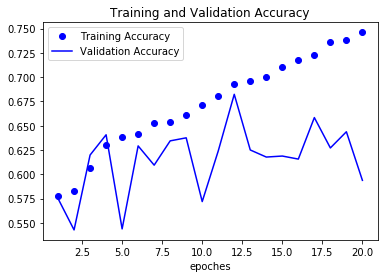

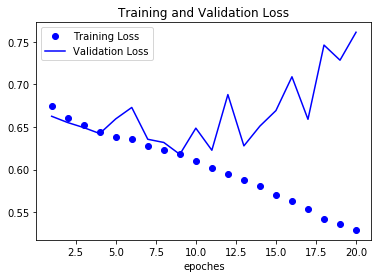

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoches')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('epoches')
plt.legend()

plt.show()

- Note that the trend of validation accuracy roughly follows the trend of the training accuracy as long as the validation loss follows the training loss, indicating that the validation data is picking up useful information from the training data.

**Conclusion**:

- Based on the results above, a sequence trimming scheme of length 1500 is indeed doing much better than a sequence trimming scheme of length 2000.
- Though the trends are similar, the validation accuracy still lags behind the training accuracy, and there still exists lots of fluctuations, indicating more areas for improvements.
- We will try a follow-up experiment with a sequence trimming scheme of length 1000.